# ML for NLP 2: Assignment 1
## Group 3: Abay Jumabayev, Damira Shaikenova

-----
**Task:**

-----
Use the samples of Twitter data posted in the Input folder (corresponding to NYT and Fox News) and do the following:

1. Data cleaning. 

Remove stopwords, links, hashtags, etc. 

2. Feature engineering.

Create popularity and engagement measures, mentions (i.e. a tweet includes @), popular hashtags, breaking news, growth of followers, an indicator if the tweet is posted by NYT, and zero if the tweet belongs to Fox News.

3. Data Exploration and Prediction.
- Is there a follower-tweet relationship? 
- What are the most frequent topics tweeted about by each outlet? Are there differences in outlets?
- Is there a relationship between the sentiment of the tweet and the outlet?
- Can we predict the outlet by the text of the tweet? Use classif micationethods (Naive Bayes, Logistic Regression, Support Vector Classifier using Count Vectorizer, Tf-Idf, or Word Embeddings). Which method performs better? Why?
- Do the usual word analogies hold in this sample?
- Create the most representative tweet by outlet

Bonus 10 points: Create at least two own explorations.

Create a GitHub repository with your code and invite me to it. 

-----

**Data:**

We start from loading some of the necessary libraries and opening the twitter data. 


In [1]:
import numpy as np
from numpy import array
import pandas as pd
import regex as re

In [2]:
df1 = pd.read_csv('Inputs/FoxNews_all_tweets.csv')
df2 = pd.read_csv('Inputs/nytimes_all_tweets.csv')

# merging two datasets 
frames = [df1, df2]
df = pd.concat(frames, ignore_index= True)

In [3]:
# dropping the columns that we will not need
df = df.drop(columns=['author_id', 'author_tweets', "author_description", "author_location", "tweet_id", "reference_status"])
df

,username,author_followers,text,created_at,retweets,replies,likes,quote_count
0,FoxNews,20946694,FLASHBACK: Ex-intel officials claimed the Hunt...,2022-03-18 15:50:00+00:00,26,39,68,0
1,FoxNews,20946694,Biden must do more to counter Putin's propagan...,2022-03-18 15:45:00+00:00,23,94,92,7
2,FoxNews,20946694,NASCAR: What to expect from Atlanta's super ne...,2022-03-18 15:40:00+00:00,10,9,21,0
3,FoxNews,20946694,"BREAKING: Biden, Xi discuss Russia's war again...",2022-03-18 15:34:43+00:00,33,71,87,3
4,FoxNews,20946694,Transgender swimmer's NCAA championship win 'j...,2022-03-18 15:30:00+00:00,51,69,254,4
...,...,...,...,...,...,...,...,...
1947,nytimes,52297191,"Kyrylo Lysov, 22, and his girlfriend Yelyzavet...",2022-03-11 16:40:18+00:00,737,170,5277,54
1948,nytimes,52297191,Our journalists are looking into how companies...,2022-03-11 16:30:12+00:00,32,38,150,7
1949,nytimes,52297191,Breaking News: Alec Baldwin gave his most deta...,2022-03-11 16:18:19+00:00,59,81,227,20
1950,nytimes,52297191,A shipwreck from 1891 has been discovered in L...,2022-03-11 16:10:04+00:00,88,15,361,16


-------
# Feature Engineering
-----

We start from feature engineering. We will conduct text data cleaning later since in this part of the task text pre-processing is either should not be done yet or not necessary at all. 

- Popularity and Engagement Measures:

We already have such popularity measures such as likes and retweets. We can create a few more popularity measures such as: likes per retweets, likes per followers (in millions). For engagement measures, we create variables such as sum of replies and quotes as well as the sum of replies and quotes per followers (in millions) to take into account different number of followers among two sources. 

In [4]:
df['likes_per_rt'] = df['likes']/df['retweets']
df['likes_per_mfllrs'] = df['likes']/df['author_followers']*1000000

df['repl_quot'] = df['replies']+df['quote_count']
df['repl_quot_per_mfllrs'] = df['repl_quot']/df['author_followers']*1000000

- Number of other accounts' mentions (@)

We use regex to find if there are any other accounts' mentions (@) in the twitter text.

In [5]:
pattern =r'@([A-Za-z0-9_]+)'

df['mentions_count'] = df['text'].apply(lambda x: len(re.findall(pattern, x)))

- Two most popular tweets' special categories: breaking news, opinion.

We create two dummy variables that would indicate whether tweet belongs to the categories of breaking news or opinions. 

In [6]:
pattern1 = r'(BREAKING:)|(Breaking News:)' # fox news and ny times have slightly different ways of indicating breaking news
df['is_breaking'] = df['text'].apply(lambda x: 1 if len(re.findall(pattern1, x))>0 else 0)

pattern2 = r'(OPINION:)|(In Opinion)'
df['is_opinion'] = df['text'].apply(lambda x: 1 if len(re.findall(pattern2, x))>0 else 0)

- Popular hashtags

Since there are only three distinctive hashtags among all tweets, we create dummy variables for each of them and also the dummy variable for the presence of any hashtag in text. In case if there were more hashtags, we would create dummy variables only for top 5 popular hashtags.

In [7]:
# counting the number of hashtags mentioned in each tweet
pattern3 =r'\B(\#[a-zA-Z]+\b)(?!;)'
df['is_hashtag'] = df['text'].apply(lambda x: len(re.findall(pattern3, x)))

In [8]:
def return_all_hashtags(tweets): 
    all_hashtags=[]
    for tweet in tweets:
        for word in tweet.split():
            if word.startswith('#'):
                word = re.sub(r'[^A-Za-z0-9 ]+', '', word) #remove all non‐alphanumeric characters except white space
                all_hashtags.append(word)      
    return all_hashtags

In [9]:
all_hashtags = return_all_hashtags(df['text'])
hashtag_dict = {i: all_hashtags.count(i) for i in all_hashtags}
hashtag_dict = dict(sorted(hashtag_dict.items(), key=lambda item: item[1], reverse=True))
hashtag_dict

{'CriticsChoice': 5, 'CriticsChoiceAwards': 3, 'MeToo': 1}

In [10]:
# choosing only top five most mentioned hashtags (three in our case)
top_hashtags = list(hashtag_dict.keys())[:5]
top_hashtags 

['CriticsChoice', 'CriticsChoiceAwards', 'MeToo']

In [11]:
# creating dummys for each of the top hashtags
for hashtag in top_hashtags:
    df['hashtag_'+hashtag] = df.text.apply(lambda x: 1 if hashtag in x else 0)

- Growth of followers 

We also create a column showing the difference between the current tweet's number of followers and the previous one. By doing this, it might be implied that any change in number of followers happens due to the last tweet posted. This is not necessarily true, however since it is impossible to guess which tweet was 'responsible' for an increase or decrease in total number of followers, we keep this assumption as it is. 

In [12]:
df['growth_fllrs'] = - df.groupby("username")["author_followers"].diff() 
df['growth_fllrs'] = df['growth_fllrs'].fillna(0)

In [13]:
# checking the values 
df[['created_at','author_followers','growth_fllrs']][1927:1931]

,created_at,author_followers,growth_fllrs
1927,2022-03-11 20:45:06+00:00,52297188,-0.0
1928,2022-03-11 20:30:13+00:00,52297188,-0.0
1929,2022-03-11 20:25:08+00:00,52297191,-3.0
1930,2022-03-11 20:15:11+00:00,52297191,-0.0


- An indicator if the tweet is posted by NYT, and zero if the tweet belongs to Fox News

In [14]:
df['is_nyt']= df['username'].apply(lambda x: 1 if x=='nytimes' else 0)

In [15]:
df.head()

,username,author_followers,text,created_at,retweets,replies,likes,quote_count,likes_per_rt,likes_per_mfllrs,...,repl_quot_per_mfllrs,mentions_count,is_breaking,is_opinion,is_hashtag,hashtag_CriticsChoice,hashtag_CriticsChoiceAwards,hashtag_MeToo,growth_fllrs,is_nyt
0,FoxNews,20946694,FLASHBACK: Ex-intel officials claimed the Hunt...,2022-03-18 15:50:00+00:00,26,39,68,0,2.615385,3.246336,...,1.861869,0,0,0,0,0,0,0,0.0,0
1,FoxNews,20946694,Biden must do more to counter Putin's propagan...,2022-03-18 15:45:00+00:00,23,94,92,7,4.000000,4.392101,...,4.821763,0,0,0,0,0,0,0,-0.0,0
2,FoxNews,20946694,NASCAR: What to expect from Atlanta's super ne...,2022-03-18 15:40:00+00:00,10,9,21,0,2.100000,1.002545,...,0.429662,0,0,0,0,0,0,0,-0.0,0
3,FoxNews,20946694,"BREAKING: Biden, Xi discuss Russia's war again...",2022-03-18 15:34:43+00:00,33,71,87,3,2.636364,4.153400,...,3.532777,0,1,0,0,0,0,0,-0.0,0
4,FoxNews,20946694,Transgender swimmer's NCAA championship win 'j...,2022-03-18 15:30:00+00:00,51,69,254,4,4.980392,12.126019,...,3.485037,0,0,0,0,0,0,0,-0.0,0


-----
# Data Exploration and Prediction 
-----
## Tweet - Follower Relationship

For each of the outlet, we want to see whether there is any relationship between tweet content and number of followers. We use VADER Sentiment Intensity Analyzer for this.

In [16]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

sentiment = SentimentIntensityAnalyzer()

**FoxNews data**

In [17]:
# estimating polarity score for each tweet
df1['polarity_score'] = df1['text'].apply(lambda x: sentiment.polarity_scores(str(x))['compound'])

# classifying tweets as positive, negative and neutral based on common thresholds for splitting Vader sentiments
df1['sentiment'] = np.where(df1['polarity_score']>0.05, "Positive", 
                          np.where(df1['polarity_score']< -0.05, "Negative", 'Neutral'))

<AxesSubplot:xlabel='sentiment', ylabel='count'>

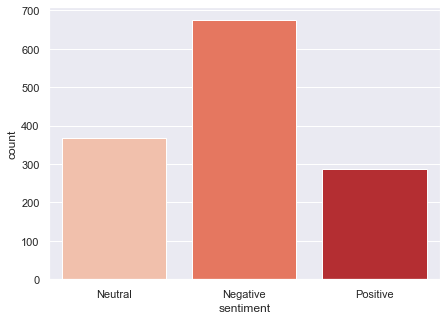

In [18]:
import seaborn as sns
sns.set(rc={"figure.figsize":(7, 5)})
sns.countplot(x='sentiment', data=df1, palette="Reds")

We can see that there are more news with Negative sentiment for Fox News. 

Now, let's check whether there is any correlation between the number of followers and polarity scores.

In [19]:
df1['polarity_score'].corr(df1['author_followers'])

0.053717506122658236

The correlation value is positive, but very small. 

Let's find correlation between the number of followers and sentiment scores instead of polarity scores.

In [20]:
df1['sentiment'] = np.where(df1['polarity_score']>0.05, 1, 
                          np.where(df1['polarity_score']< -0.05, -1, 0))

df1['sentiment'].corr(df1['author_followers'])

0.04273945202796756

The result has not changed much. Positive sign implies that increase in sentiment/polarity score is associated with in increase in followers for Fox News, however the value is too small. 

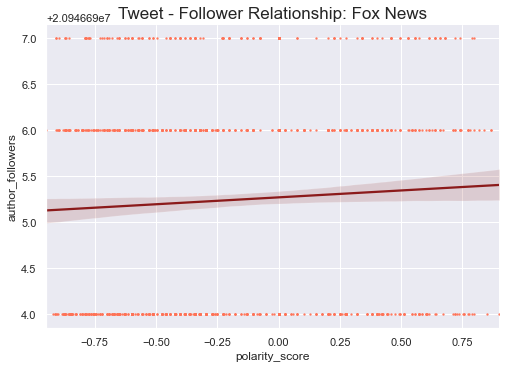

In [21]:
import matplotlib.pyplot as plt

sns.lmplot(x = "polarity_score", y = 'author_followers', data = df1, 
           scatter_kws ={'color': '#FF7256', 's':2}, line_kws={'color': '#8B1A1A'}, 
           height=5, aspect=1.4, legend=False )
sns.color_palette("Reds")

ax = plt.gca()
ax.set_title("Tweet - Follower Relationship: Fox News", fontsize=17)
plt.show()

As we can see, the slope is positive but at the same time very small. Partially the reason for this is that there is no variability in the followers number. For such a short period, the number of followers increased and decreased only few times by 1-6 followers.

**NYTimes data**

In [22]:
df2['polarity_score'] = df2['text'].apply(lambda x: sentiment.polarity_scores(str(x))['compound'])
df2['sentiment'] = np.where(df2['polarity_score']>0.05, "Positive", 
                          np.where(df2['polarity_score']< -0.05, "Negative", 'Neutral'))

<AxesSubplot:xlabel='sentiment', ylabel='count'>

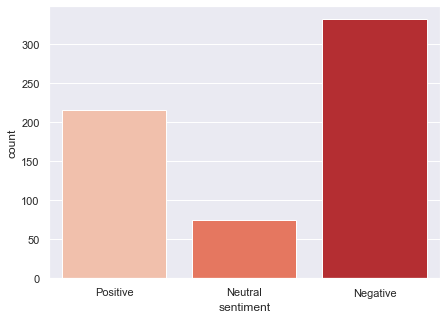

In [23]:
sns.countplot(x='sentiment', data=df2, palette="Reds")

We can see that there are more news with Negative sentiment. 

Now, let's check whether there is any correlation between the number of followers and polarity/sentiment scores.

In [24]:
df2['polarity_score'].corr(df2['author_followers'])

-0.03855869395832605

In [25]:
df2['sentiment'] = np.where(df2['polarity_score']>0.05, 1, 
                          np.where(df2['polarity_score']< -0.05, -1, 0))
df2['sentiment'].corr(df2['author_followers'])

-0.03424046821084184

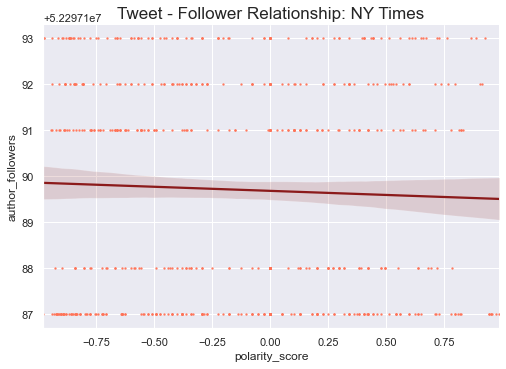

In [26]:
sns.lmplot(x = "polarity_score", y = 'author_followers', data = df2, 
           scatter_kws ={'color': '#FF7256', 's':2}, line_kws={'color': '#8B1A1A'}, 
           height=5, aspect=1.4, legend=False )
sns.color_palette("Reds")

ax = plt.gca()
ax.set_title("Tweet - Follower Relationship: NY Times", fontsize=17)
plt.show()

As we can see, for NY times, the correlation is now negative but still very low, almost zero. Once again we think that with greater  variability in the followers number the results could be more meaningfull.

------

## The most frequent topics tweeted about by each outlet

#### Preprocess data

In [27]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer, LancasterStemmer 

In [28]:
# load the stopword list provided by the NLTK library
stop_words = stopwords.words('english')

# think of twitter/news specific stopwords 
stopwords_verbs = ['said', 'writes', 'take','get','may','say', 'get', 'go', 'know', 'may', 'need', 'like', 'make', 'see', 'want', 'come', 'take', 'use', 'would', 'can']
stopwords_other = ['according', 'one', 'mr', 'bbc', 'image', 'getty', 'de', 'en', 'caption', 'also', 'copyright', 'something', 'u']

stop_words = stop_words + stopwords_verbs + stopwords_other

Let's define a function **preprocessing_text** that takes text as input an does the following:
* replaces all non-alphanumeric characters with spaces
* replaces 3+ consecutive letters to one. e.g. looooove -> love
* removes all emails
* removes all urls
* replaces all letters to lower case
* removes stopwords (nltk stopwords)
* removes words with digits
* conducts a lemmatization

In [29]:
def preprocessing_text(text):
    text = re.sub(r'([a-z0-9+._-]+@[a-z0-9+._-]+\.[a-z0-9+_-]+)',"", text) # remove emails
    text = re.sub(r'(http|https|ftp|ssh)://([\w_-]+(?:(?:\.[\w_-]+)+))([\w.,@?^=%&:/~+#-]*[\w@?^=%&/~+#-])?', '' , text) # remove urls
    text = re.sub(r'[^A-Za-z0-9 ]+', ' ', text) #remove all non‐alphanumeric characters except white space
    text = re.sub("(.)\\1{2,}", "\\1", text) #replace 3+ consecutive letters to 1 (loooovvvve -> love)
    words = word_tokenize(text.lower())
    tokens = [word for word in words if word not in stop_words]
    tokens = [token for token in tokens if not any(c.isdigit() for c in token)] #remove everything containing digits
    lemmatizer = WordNetLemmatizer()
    tokens_lematized = [lemmatizer.lemmatize(word) for word in tokens]
    preprocessed_text = ' '.join(tokens_lematized)
    return preprocessed_text

In [30]:
%%time
df1['text'] = df1['text'].apply(lambda x: preprocessing_text(x))

CPU times: total: 1.61 s
Wall time: 1.6 s


In [31]:
%%time
df2['text'] = df2['text'].apply(lambda x: preprocessing_text(x))

CPU times: total: 312 ms
Wall time: 291 ms


#### Use count vectorizer

In [32]:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer1 = CountVectorizer()
vectorizer2 = CountVectorizer()

count1 = vectorizer1.fit_transform(df1.text)
count2 = vectorizer2.fit_transform(df2.text)

Let's first have a look at the top common words mentioned by senators in their speeches.

In [33]:
df1_top_words = pd.DataFrame(count1.toarray().transpose(), index=vectorizer1.get_feature_names())

#Creating a column that would show the total number of mentions for each of the word/token
df1_top_words.loc[:,'Total'] = df1_top_words.sum(axis=1) 
df1_top_words = df1_top_words.sort_values(by='Total', ascending=False)
df1_top_words.head(10)
# For Fox News:

,0,1,2,3,4,5,6,7,8,9,...,1320,1321,1322,1323,1324,1325,1326,1327,1328,Total
ukraine,0,0,0,1,0,0,0,0,1,1,...,0,0,0,0,0,1,0,1,0,263
biden,1,1,0,1,0,0,1,1,0,0,...,0,0,1,0,0,0,1,0,0,206
russia,0,0,0,1,0,0,0,1,0,0,...,0,0,0,0,0,1,0,0,1,184
war,0,0,0,1,0,0,0,1,0,0,...,0,0,0,0,0,1,0,0,0,141
russian,1,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,140
say,0,0,0,0,0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,133
putin,0,1,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,98
ukrainian,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,67
zelenskyy,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,67
new,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,64


In [34]:
df2_top_words = pd.DataFrame(count2.toarray().transpose(), index=vectorizer2.get_feature_names())

#Creating a column that would show the total number of mentions for each of the word/token
df2_top_words.loc[:,'Total'] = df2_top_words.sum(axis=1) 
df2_top_words = df2_top_words.sort_values(by='Total', ascending=False)
df2_top_words.head(10)
# For NY times:

,0,1,2,3,4,5,6,7,8,9,...,614,615,616,617,618,619,620,621,622,Total
ukraine,0,0,0,0,1,1,0,1,0,0,...,0,0,0,0,1,0,0,0,0,179
russia,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,1,134
russian,0,0,0,0,0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,1,117
new,0,1,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,1,0,0,85
war,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,83
president,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,79
city,2,0,1,0,0,0,0,0,1,0,...,0,0,1,0,0,0,0,0,0,70
year,0,1,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,67
ukrainian,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,63
people,1,0,0,0,0,0,1,0,0,1,...,0,0,0,0,0,0,0,0,0,62


Above we can see the common words for two of the news outlets. We can observe that almost 20% of tweets included the words related to Russia-Ukraine conflict (for both outlets).

Let's now perform LDA and see whether there are other topics as well.

First prepare text for LDA. Transform each tweet to a list of words:

In [35]:
from nltk.tokenize import RegexpTokenizer
import re
tokenizer = RegexpTokenizer(r'\w+')

def prepare_text_for_lda(text):
    text= re.sub(r'\d', '', text)
    tokens = tokenizer.tokenize(text.lower())
    return tokens

In [36]:
df1['tokens'] = df1['text'].apply(lambda x: prepare_text_for_lda(x))
df2['tokens'] = df2['text'].apply(lambda x: prepare_text_for_lda(x))

Second, create dictionary and corpus. Separately for two news outlets of course

In [37]:
from gensim import corpora

dictionary_LDA1 = corpora.Dictionary(df1['tokens'].tolist())
dictionary_LDA2 = corpora.Dictionary(df2['tokens'].tolist())

corpus1 = [dictionary_LDA1.doc2bow(tok) for tok in df1['tokens'].tolist()]
corpus2 = [dictionary_LDA2.doc2bow(tok) for tok in df2['tokens'].tolist()]

Third, let's look on topics.

We assume that there might be up to **ten** topics: Politics, Business, Tech, Science, Health, Sports, Arts, Style, Showbiz. 

Maybe we can even shorten the number of topics to **five**: Politics, Business, Entertainment, Sports, Lifestyle.

Let's see how LDA performs for both outlets:

### Foxnews, 10 topics

In [38]:
from gensim import models

num_topics = 10
lda_model1 = models.LdaModel(corpus1, num_topics=num_topics,
                            random_state=100,
                            id2word=dictionary_LDA1, 
                            passes=4)

In [39]:
for i,topic in lda_model1.show_topics(formatted=True, num_topics=num_topics, num_words=20):
    print(str(i)+": "+ topic + "\n")


0: 0.014*"russia" + 0.010*"say" + 0.008*"jussie" + 0.008*"smollett" + 0.008*"u" + 0.007*"actor" + 0.007*"house" + 0.007*"kim" + 0.007*"ukraine" + 0.006*"russian" + 0.005*"war" + 0.005*"nuclear" + 0.005*"white" + 0.005*"official" + 0.005*"covid" + 0.005*"tell" + 0.005*"plan" + 0.005*"report" + 0.005*"sentencing" + 0.005*"davidson"

1: 0.026*"biden" + 0.016*"say" + 0.015*"russia" + 0.012*"ukraine" + 0.011*"russian" + 0.009*"war" + 0.008*"time" + 0.007*"u" + 0.007*"energy" + 0.006*"amid" + 0.006*"new" + 0.006*"zelenskyy" + 0.006*"iran" + 0.005*"call" + 0.005*"york" + 0.005*"chief" + 0.005*"admin" + 0.004*"home" + 0.004*"talk" + 0.004*"nato"

2: 0.020*"u" + 0.010*"putin" + 0.010*"zelenskyy" + 0.009*"ukraine" + 0.009*"say" + 0.008*"russia" + 0.006*"president" + 0.006*"school" + 0.006*"fight" + 0.005*"biden" + 0.005*"crime" + 0.004*"house" + 0.004*"time" + 0.004*"woman" + 0.004*"break" + 0.004*"police" + 0.004*"threat" + 0.004*"war" + 0.003*"expert" + 0.003*"state"

3: 0.018*"biden" + 0.018*

### Foxnews, 5 topics

In [40]:
num_topics = 5
lda_model1 = models.LdaModel(corpus1, num_topics=num_topics,
                            random_state=100,
                            id2word=dictionary_LDA1, 
                            passes=4)

In [41]:
for i,topic in lda_model1.show_topics(formatted=True, num_topics=num_topics, num_words=20):
    print(str(i)+": "+ topic + "\n")

0: 0.016*"russia" + 0.010*"say" + 0.007*"ukraine" + 0.007*"jussie" + 0.007*"smollett" + 0.006*"biden" + 0.005*"u" + 0.005*"house" + 0.005*"russian" + 0.005*"war" + 0.004*"official" + 0.004*"report" + 0.004*"covid" + 0.004*"white" + 0.004*"kim" + 0.004*"tell" + 0.004*"jail" + 0.003*"people" + 0.003*"ahead" + 0.003*"plan"

1: 0.023*"biden" + 0.015*"ukraine" + 0.012*"russia" + 0.011*"say" + 0.008*"war" + 0.006*"new" + 0.006*"amid" + 0.006*"zelenskyy" + 0.006*"call" + 0.005*"energy" + 0.005*"ukrainian" + 0.005*"time" + 0.005*"russian" + 0.005*"u" + 0.004*"american" + 0.004*"former" + 0.004*"cnn" + 0.004*"putin" + 0.003*"york" + 0.003*"trump"

2: 0.018*"ukraine" + 0.012*"russia" + 0.011*"u" + 0.010*"zelenskyy" + 0.009*"biden" + 0.008*"putin" + 0.006*"president" + 0.006*"war" + 0.006*"say" + 0.006*"congress" + 0.005*"expert" + 0.004*"call" + 0.004*"energy" + 0.004*"address" + 0.004*"fight" + 0.004*"opinion" + 0.003*"threat" + 0.003*"nyc" + 0.003*"ukrainian" + 0.003*"break"

3: 0.016*"biden" 

For FoxNews, it doesn't seem that LDA is performing a good job. Every topic has words related to Russia-Ukraine conflict.

Probably we will delete the most popular words and then perform analysis one more time

Now, let's look on NYTimes:

### NYTimes, 10 topics

In [42]:
num_topics = 10
lda_model2 = models.LdaModel(corpus2, num_topics=num_topics,
                            random_state=100,
                            id2word=dictionary_LDA2, 
                            passes=4)

In [43]:
for i,topic in lda_model2.show_topics(formatted=True, num_topics=num_topics, num_words=20):
    print(str(i)+": "+ topic + "\n")

0: 0.012*"new" + 0.009*"ukraine" + 0.008*"two" + 0.008*"city" + 0.007*"russian" + 0.007*"york" + 0.006*"people" + 0.006*"war" + 0.006*"russia" + 0.005*"time" + 0.004*"channel" + 0.004*"president" + 0.004*"men" + 0.004*"year" + 0.004*"since" + 0.003*"kyiv" + 0.003*"breaking" + 0.003*"world" + 0.003*"covid" + 0.003*"wednesday"

1: 0.009*"ukraine" + 0.008*"city" + 0.008*"ukrainian" + 0.006*"day" + 0.005*"company" + 0.005*"new" + 0.005*"news" + 0.004*"war" + 0.004*"russian" + 0.004*"journalist" + 0.004*"month" + 0.004*"force" + 0.004*"next" + 0.004*"monday" + 0.004*"opinion" + 0.003*"every" + 0.003*"resident" + 0.003*"end" + 0.003*"state" + 0.003*"kyiv"

2: 0.011*"city" + 0.010*"russian" + 0.009*"ukraine" + 0.006*"year" + 0.005*"new" + 0.005*"war" + 0.005*"two" + 0.004*"killed" + 0.004*"ukrainian" + 0.004*"least" + 0.004*"woman" + 0.004*"kyiv" + 0.004*"even" + 0.004*"death" + 0.004*"number" + 0.004*"state" + 0.004*"people" + 0.004*"york" + 0.004*"anna" + 0.003*"show"

3: 0.008*"russian" + 

### NYTimes, 5 topics

In [44]:
num_topics = 5
lda_model2 = models.LdaModel(corpus2, num_topics=num_topics,
                            random_state=100,
                            id2word=dictionary_LDA2, 
                            passes=4)

In [45]:
for i,topic in lda_model2.show_topics(formatted=True, num_topics=num_topics, num_words=20):
    print(str(i)+": "+ topic + "\n")

0: 0.011*"president" + 0.010*"new" + 0.009*"ukraine" + 0.008*"russian" + 0.007*"russia" + 0.006*"city" + 0.006*"biden" + 0.006*"people" + 0.006*"world" + 0.005*"two" + 0.005*"war" + 0.005*"news" + 0.004*"york" + 0.004*"time" + 0.004*"state" + 0.004*"breaking" + 0.004*"wednesday" + 0.004*"zelensky" + 0.003*"country" + 0.003*"covid"

1: 0.012*"ukraine" + 0.006*"ukrainian" + 0.006*"war" + 0.006*"russia" + 0.006*"people" + 0.005*"russian" + 0.005*"country" + 0.004*"new" + 0.004*"city" + 0.004*"monday" + 0.004*"day" + 0.003*"news" + 0.003*"invasion" + 0.003*"two" + 0.003*"year" + 0.003*"un" + 0.003*"attack" + 0.003*"time" + 0.003*"company" + 0.003*"fleeing"

2: 0.013*"ukraine" + 0.010*"russian" + 0.008*"city" + 0.007*"year" + 0.006*"war" + 0.005*"ukrainian" + 0.005*"new" + 0.004*"day" + 0.004*"russia" + 0.004*"people" + 0.004*"kyiv" + 0.004*"president" + 0.004*"two" + 0.004*"killed" + 0.003*"could" + 0.003*"least" + 0.003*"american" + 0.003*"york" + 0.003*"show" + 0.003*"died"

3: 0.008*"ru

The situation is similar to Fox News. 

To improve the situation, let's get rid of most common words used by each outlet. 

### LDA without common words

In [46]:
# Creating 'stop word' list from top 10 common words 
common_words1 = df1_top_words.index.values[:].tolist()[0:10]
common_words2 = df2_top_words.index.values[:].tolist()[0:10]

In [47]:
from nltk.stem.wordnet import WordNetLemmatizer
from nltk import pos_tag
from nltk.corpus import wordnet

def get_lemma(element):
    for word, pos in pos_tag(element.split()):
        result_pos=wordnet_pos(pos)
        if result_pos != None:
            return WordNetLemmatizer().lemmatize(word, result_pos)
        else:
            return word

# original example can be found here https://stackoverflow.com/a/15590384
def wordnet_pos(treebank_tag):
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return None
        
def remove_common_words(list_element, common_words):
    tokens = [get_lemma(token) for token in list_element]
    tokens = [token for token in tokens if token not in common_words]
    tokens = [token for token in tokens if len(token) > 2]
    return tokens

In [48]:
df1['tokens'] = df1['tokens'].apply(lambda sentences: remove_common_words(sentences, common_words1))
df2['tokens'] = df2['tokens'].apply(lambda sentences: remove_common_words(sentences, common_words2))

In [49]:
dictionary_LDA1 = corpora.Dictionary(df1['tokens'].tolist())
dictionary_LDA2 = corpora.Dictionary(df2['tokens'].tolist())

corpus1 = [dictionary_LDA1.doc2bow(tok) for tok in df1['tokens'].tolist()]
corpus2 = [dictionary_LDA2.doc2bow(tok) for tok in df2['tokens'].tolist()]

### Foxnews

In [50]:
num_topics = 10
lda_model1 = models.LdaModel(corpus1, num_topics=num_topics,
                            random_state=100,
                            id2word=dictionary_LDA1, 
                            passes=4)

In [51]:
for i,topic in lda_model1.show_topics(formatted=True, num_topics=num_topics, num_words=20):
    print(str(i)+": "+ topic + "\n")


0: 0.009*"amid" + 0.007*"get" + 0.007*"price" + 0.007*"gas" + 0.007*"call" + 0.006*"covid" + 0.006*"high" + 0.006*"kyiv" + 0.006*"make" + 0.006*"give" + 0.005*"congress" + 0.005*"kim" + 0.005*"opinion" + 0.005*"blame" + 0.005*"american" + 0.005*"official" + 0.005*"fight" + 0.005*"police" + 0.005*"political" + 0.004*"china"

1: 0.009*"release" + 0.008*"nyc" + 0.008*"official" + 0.006*"suspect" + 0.005*"show" + 0.005*"crime" + 0.005*"old" + 0.004*"rule" + 0.004*"baldwin" + 0.004*"star" + 0.004*"homeless" + 0.004*"arrest" + 0.004*"medium" + 0.004*"message" + 0.004*"issue" + 0.004*"amid" + 0.004*"mayor" + 0.004*"sanction" + 0.004*"invasion" + 0.004*"foreign"

2: 0.009*"kill" + 0.008*"time" + 0.007*"covid" + 0.006*"people" + 0.006*"since" + 0.005*"former" + 0.005*"journalist" + 0.005*"price" + 0.005*"sell" + 0.005*"york" + 0.005*"year" + 0.005*"republican" + 0.005*"city" + 0.005*"gas" + 0.005*"contributor" + 0.004*"official" + 0.004*"kyiv" + 0.004*"warns" + 0.004*"nuclear" + 0.004*"issue"



In [52]:
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
pyLDAvis.enable_notebook()
vis = gensimvis.prepare(topic_model=lda_model1, corpus=corpus1, dictionary=dictionary_LDA1)
pyLDAvis.display(vis)

C:\Users\exile\anaconda3\lib\site-packages\pyLDAvis\_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(


The graph above suggests that there are 5 topics, let's try doing five topics and decide whether they make sense

In [53]:
num_topics = 5
lda_model1 = models.LdaModel(corpus1, num_topics=num_topics,
                            random_state=100,
                            id2word=dictionary_LDA1, 
                            passes=4)

for i,topic in lda_model1.show_topics(formatted=True, num_topics=num_topics, num_words=20):
    print(str(i)+": "+ topic + "\n")

0: 0.007*"fight" + 0.006*"opinion" + 0.006*"give" + 0.006*"invasion" + 0.006*"price" + 0.005*"get" + 0.005*"kyiv" + 0.005*"covid" + 0.005*"high" + 0.005*"fly" + 0.005*"zone" + 0.005*"amid" + 0.005*"make" + 0.004*"president" + 0.004*"gas" + 0.004*"call" + 0.004*"american" + 0.004*"official" + 0.004*"blame" + 0.003*"view"

1: 0.007*"amid" + 0.005*"release" + 0.005*"suspect" + 0.005*"sanction" + 0.005*"nyc" + 0.004*"medium" + 0.004*"show" + 0.004*"crime" + 0.004*"invasion" + 0.004*"gop" + 0.004*"expert" + 0.004*"official" + 0.004*"york" + 0.003*"smollett" + 0.003*"jussie" + 0.003*"time" + 0.003*"police" + 0.003*"energy" + 0.003*"lawmaker" + 0.003*"world"

2: 0.007*"covid" + 0.007*"price" + 0.006*"gas" + 0.005*"time" + 0.005*"oil" + 0.004*"report" + 0.004*"leader" + 0.004*"former" + 0.004*"official" + 0.004*"year" + 0.004*"warns" + 0.004*"back" + 0.004*"home" + 0.004*"tax" + 0.004*"slam" + 0.003*"woman" + 0.003*"call" + 0.003*"people" + 0.003*"bill" + 0.003*"gop"

3: 0.006*"call" + 0.005*"

Let's try to sum up the topics:
1. Russian-Ukrainian conflict
2. US Crimes
3. Oil, gas, and sanctions
4. US Politics
5. US Economy


### NYTimes, 10 topics

In [54]:
num_topics = 10
lda_model2 = models.LdaModel(corpus2, num_topics=num_topics,
                            random_state=100,
                            id2word=dictionary_LDA2, 
                            passes=4)

In [55]:
for i,topic in lda_model2.show_topics(formatted=True, num_topics=num_topics, num_words=20):
    print(str(i)+": "+ topic + "\n")

0: 0.007*"official" + 0.007*"zelensky" + 0.006*"volodymyr" + 0.005*"congress" + 0.005*"white" + 0.005*"invasion" + 0.005*"address" + 0.005*"state" + 0.005*"house" + 0.005*"defense" + 0.004*"two" + 0.004*"day" + 0.004*"sunday" + 0.004*"security" + 0.004*"wednesday" + 0.004*"show" + 0.003*"sanction" + 0.003*"home" + 0.003*"test" + 0.003*"role"

1: 0.012*"two" + 0.010*"news" + 0.008*"world" + 0.007*"york" + 0.006*"break" + 0.005*"shot" + 0.005*"injured" + 0.005*"come" + 0.005*"large" + 0.005*"woman" + 0.005*"men" + 0.005*"police" + 0.004*"old" + 0.004*"analysis" + 0.004*"doug" + 0.004*"far" + 0.004*"country" + 0.004*"five" + 0.004*"believe" + 0.004*"pandemic"

2: 0.009*"kill" + 0.006*"country" + 0.006*"kyiv" + 0.006*"force" + 0.006*"zelensky" + 0.006*"military" + 0.005*"two" + 0.005*"invasion" + 0.005*"time" + 0.005*"least" + 0.005*"volodymyr" + 0.005*"flee" + 0.005*"show" + 0.005*"york" + 0.004*"day" + 0.004*"since" + 0.004*"die" + 0.004*"civilian" + 0.004*"make" + 0.004*"building"

3: 0

In [56]:
pyLDAvis.enable_notebook()
vis = gensimvis.prepare(topic_model=lda_model2, corpus=corpus2, dictionary=dictionary_LDA2)
pyLDAvis.display(vis)

C:\Users\exile\anaconda3\lib\site-packages\pyLDAvis\_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(


The graph above suggests that there are 4 topics, let's try doing six topics and decide whether they make sense

In [57]:
num_topics = 4
lda_model2 = models.LdaModel(corpus2, num_topics=num_topics,
                            random_state=100,
                            id2word=dictionary_LDA2, 
                            passes=4)
for i,topic in lda_model2.show_topics(formatted=True, num_topics=num_topics, num_words=20):
    print(str(i)+": "+ topic + "\n")

0: 0.005*"official" + 0.004*"state" + 0.004*"two" + 0.004*"show" + 0.004*"test" + 0.004*"sanction" + 0.003*"week" + 0.003*"court" + 0.003*"day" + 0.003*"kill" + 0.003*"force" + 0.003*"woman" + 0.003*"sunday" + 0.003*"attack" + 0.003*"invasion" + 0.003*"last" + 0.003*"country" + 0.003*"house" + 0.003*"coronavirus" + 0.003*"least"

1: 0.007*"two" + 0.007*"world" + 0.005*"news" + 0.005*"country" + 0.005*"china" + 0.005*"biden" + 0.004*"york" + 0.004*"day" + 0.004*"break" + 0.004*"state" + 0.003*"men" + 0.003*"kill" + 0.003*"american" + 0.003*"since" + 0.003*"shot" + 0.003*"pandemic" + 0.003*"around" + 0.003*"washington" + 0.003*"begin" + 0.002*"die"

2: 0.006*"country" + 0.006*"invasion" + 0.005*"kill" + 0.005*"time" + 0.005*"zelensky" + 0.005*"kyiv" + 0.004*"tuesday" + 0.004*"volodymyr" + 0.004*"could" + 0.004*"attack" + 0.004*"military" + 0.004*"two" + 0.004*"since" + 0.004*"flee" + 0.004*"help" + 0.004*"official" + 0.004*"biden" + 0.004*"day" + 0.003*"million" + 0.003*"york"

3: 0.004*

Let's try to sum up the topics:
1. Museum attack
2. US-China relations
3. Russian-Ukrainian conflict
4. Covid situation

Overall, we can conclude that there are no obvious differences in outlets based on their most frequent topics. 

----

## Tweet Sentiment - Outlet Relationship

Let's see whether there is any relationship between the sentiment of the tweet and the outlet. We can start from creating a sentiment score for all tweets and checking whether there is any correlation between outlet and polarity/sentiment scores

In [58]:
# creating separate dataframe with only currently necessary columns 
df_sentim = df[['text','created_at','is_nyt']].copy()

In [59]:
df_sentim['polarity_score'] = df_sentim['text'].apply(lambda x: sentiment.polarity_scores(str(x))['compound'])
df_sentim['sentiment'] = np.where(df_sentim['polarity_score']>0.05, "Positive", 
                          np.where(df_sentim['polarity_score']< -0.05, "Negative", 'Neutral'))
df_sentim

,text,created_at,is_nyt,polarity_score,sentiment
0,FLASHBACK: Ex-intel officials claimed the Hunt...,2022-03-18 15:50:00+00:00,0,0.0000,Neutral
1,Biden must do more to counter Putin's propagan...,2022-03-18 15:45:00+00:00,0,-0.2500,Negative
2,NASCAR: What to expect from Atlanta's super ne...,2022-03-18 15:40:00+00:00,0,0.5994,Positive
3,"BREAKING: Biden, Xi discuss Russia's war again...",2022-03-18 15:34:43+00:00,0,-0.5994,Negative
4,Transgender swimmer's NCAA championship win 'j...,2022-03-18 15:30:00+00:00,0,0.7717,Positive
...,...,...,...,...,...
1947,"Kyrylo Lysov, 22, and his girlfriend Yelyzavet...",2022-03-11 16:40:18+00:00,1,-0.1779,Negative
1948,Our journalists are looking into how companies...,2022-03-11 16:30:12+00:00,1,0.0772,Positive
1949,Breaking News: Alec Baldwin gave his most deta...,2022-03-11 16:18:19+00:00,1,-0.6486,Negative
1950,A shipwreck from 1891 has been discovered in L...,2022-03-11 16:10:04+00:00,1,0.2960,Positive


In [60]:
df_sentim['polarity_score'].corr(df_sentim['is_nyt'])

0.006947711602763024

In [61]:
df_sentim['sentiment'] = np.where(df_sentim['polarity_score']>0.05, 1, 
                          np.where(df_sentim['polarity_score']< -0.05, -1, 0))

df_sentim['sentiment'].corr(df_sentim['is_nyt'])

0.057776838311044576

The correlation does not seem to be high, providing us no clear indication that one of the outlets is more negative or positive than another. Let's see how average sentiments of each outlet vary across time.

In [62]:
from datetime import datetime

df_sentim['created_at'] = df_sentim['created_at'].apply(lambda x: datetime.strptime(x,'%Y-%m-%d %H:%M:%S+00:00'), '%Y-%m-%d %H:%M:%S')

In [63]:
# We want to divide each day in 4 parts (6 hours) and calculate average twitters sentiment for each of the time period. 

df_sentim['time'] =  df_sentim['created_at'].apply(lambda x: x.day if (x.hour>=0 and x.hour<6) 
                                                   else (x.day+ 0.25 if (x.hour>=6 and x.hour<12) else
                                                        (x.day+0.5 if (x.hour>=12 and x.hour<18) else x.day+0.75)))


In [64]:
df3 = df_sentim.groupby(['is_nyt','time'], as_index=False).mean()
df3['sentiment'] = np.where(df3['polarity_score']>0.05, 1, 
                          np.where(df3['polarity_score']< -0.05, -1, 0))

df3.head()

,is_nyt,time,polarity_score,sentiment
0,0,11.50,-0.242918,-1
1,0,11.75,-0.074763,-1
2,0,12.00,-0.234811,-1
3,0,12.25,-0.142454,-1
4,0,12.50,-0.064128,-1


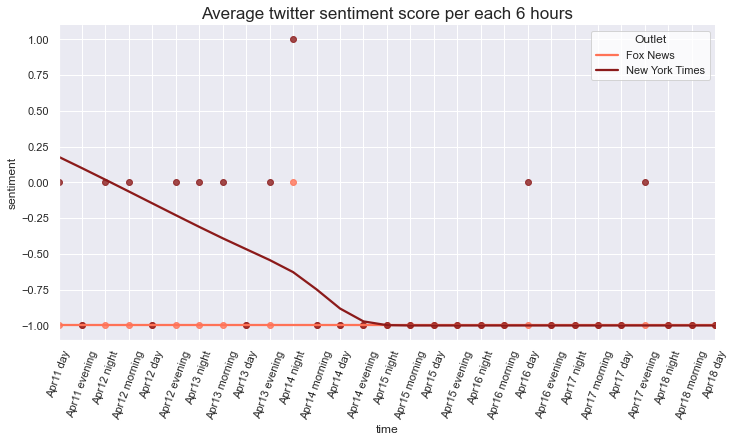

In [67]:
colors = ['#FF7256', '#8B1A1A'] 

sns.set(rc={"figure.figsize":(5, 15)})
sns.lmplot(x = 'time', y = 'sentiment', data = df3, hue = 'is_nyt', palette = colors, lowess=True, 
               height=5, aspect=2, legend=False )
ax = plt.gca()
ax.set_title("Average twitter sentiment score per each 6 hours", fontsize=17)
ax.legend(title='Outlet', labels=['Fox News', 'New York Times'], facecolor='white')
ax.set_xticks(df3['time'][:29])

# modify labels for x ticks to have a format 'Apr 18 morning'
xticks = df3['time'][:29]
xticks = xticks.apply(lambda x: 'Apr'+ str(int(x))+ ' night' if x%1==0 else 
             'Apr'+ str(int(x))+ ' morning' if x%1==0.25 else
             'Apr'+ str(int(x))+ ' day' if x%1==0.5 else 'Apr'+ str(int(x))+ ' evening'
            )

ax.set_xticklabels(xticks, rotation =70)
plt.show()

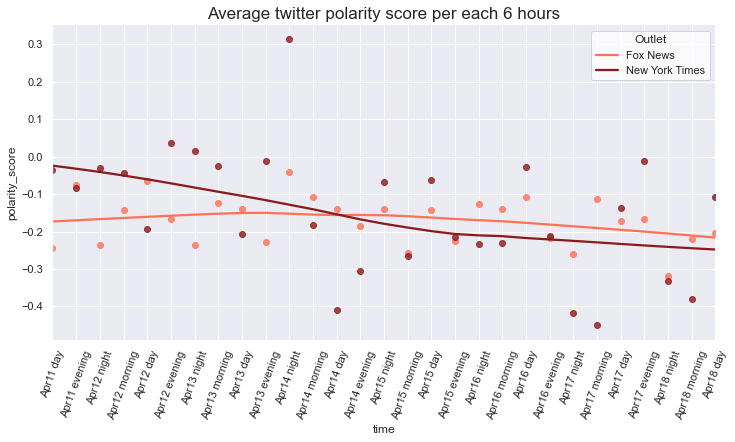

In [68]:
sns.lmplot(x = 'time', y = 'polarity_score', data = df3, hue = 'is_nyt', palette = colors, lowess=True, 
               height=5, aspect=2, legend=False )
ax = plt.gca()
ax.set_title("Average twitter polarity score per each 6 hours", fontsize=17)
ax.legend(title='Outlet', labels=['Fox News', 'New York Times'], facecolor='white')
ax.set_xticks(df3['time'][:29])

# modify labels for x ticks to have a format 'Apr 18 morning'
xticks = df3['time'][:29]
xticks = xticks.apply(lambda x: 'Apr'+ str(int(x))+ ' night' if x%1==0 else 
             'Apr'+ str(int(x))+ ' morning' if x%1==0.25 else
             'Apr'+ str(int(x))+ ' day' if x%1==0.5 else 'Apr'+ str(int(x))+ ' evening'
            )

ax.set_xticklabels(xticks, rotation =70)
plt.show()

Once we grouped tweets by smaller time periods and compared average tweet sentiments between two outlets, the graphs show us that initially (between April 11 and April 14) New York Times' tweets were more positive, on average, than Fox News' tweets. After that, both New York Times and Fox News had negative sentiment scores, on average, with Fox News having slighly higher higher average compound polarity score. 

Overall, New York Times' tweets look a bit more neutral and less negative than Fox News tweets. 